# MNIST


The MNIST dataset is one of the widely used datasets in image classification, but it is too simple as a benchmark dataset. Therefore, we will use the Fashion-MNIST dataset, which is similar but more complex.

In [111]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

import time
from contextlib import contextmanager


# 设置 Matplotlib 的后端为 SVG
%config InlineBackend.figure_format = 'svg'


In [112]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data",
    train=True,
    transform=trans,
    download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data",
    train=False,
    transform=trans,
    download=True
)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [113]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

visulizaion

In [114]:
def get_fashion_mnist_labels(labels):
  """
  return Fashion-MNIST dataset labels
  """
  text_labels=[
      't-shirt',
      'trouser',
      'pullover',
      'dress',
      'coat',
      'sandal',
      'shirt',
      'sneaker',
      'bag',
      'ankle boot'
  ]
  return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        # 确保图像数据是 NumPy 数组，并且是灰度图
        if torch.is_tensor(img):
            ax.imshow(img.squeeze().numpy(), cmap='gray')  # 使用灰度图
        else:
            ax.imshow(img, cmap='gray')
        if title:
            ax.set_title(title[i])  # 为每个子图设置标题
        ax.axis('off')  # 关闭坐标轴
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

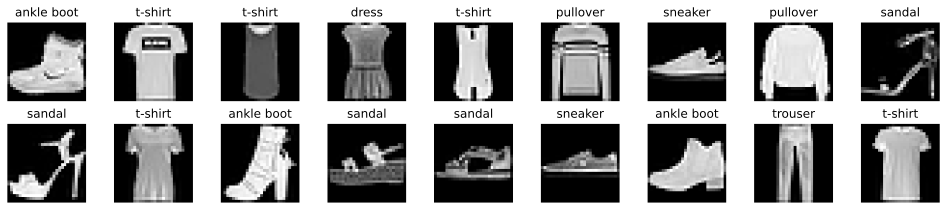

In [115]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))

# 显示图像和标签
show_images(X, 2, 9, title=get_fashion_mnist_labels(y))

read a small batch data with size `batch_size`

In [116]:
batch_size = 256

def get_dataloader_workers():
  """
  use 4 CIP
  """
  return 4

train_iter = data.DataLoader(
    mnist_train,
    batch_size,
    shuffle=True,
    num_workers=get_dataloader_workers()
)


@contextmanager
def timer():
    start_time = time.time()
    try:
        yield
    finally:
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.6f} seconds")

# reading data timer
with timer():
    for X, y in train_iter:
      continue

Elapsed time: 7.280185 seconds


In [117]:
def load_data_fashion_mnist(batch_size, resize=None):
  """
  download Fashion-MNIST dataset and read it into memory
  """
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
    root="../data",
    train=True,
    transform=trans,
    download=True
  )
  mnist_test = torchvision.datasets.FashionMNIST(
    root="../data",
    train=False,
    transform=trans,
    download=True
  )
  return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
          data.DataLoader(mnist_test, batch_size, shuffle=True,num_workers=get_dataloader_workers()))



# Softmax Regression

In [118]:
import torch
import matplotlib.pyplot as plt
from IPython import display

# 假设 load_data_fashion_mnist 已正确加载数据
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

def softmax(x):
    X_exp = torch.exp(x)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

def net(X):
    X = X.reshape((-1, W.shape[0]))  # 确保 X 的形状是 (batch_size, num_inputs)
    return softmax(torch.matmul(X, W) + b)

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, dim=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        y_hat = net(X)
        metric.add(accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: plt.xlabel(xlabel).ylabel(ylabel).xlim(xlim).ylim(ylim).xscale(xscale).yscale(yscale)
        self.X, self.Y, self.fmts, self.legend = None, None, fmts, legend

    def add(self, x, y):
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(self.X, "__len__"):
            self.X = [[] for _ in range(n)]
        if not hasattr(self.Y, "__len__"):
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(y, self.Y)):
            a = [a] if not isinstance(a, list) else a
            self.X[i].extend(x)
            self.Y[i].extend(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        self.axes[0].legend(self.legend)
        display.display(self.fig)
        display.clear

In [119]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', ylabel='loss/accuracy', legend=['train loss', 'train acc', 'test acc'],
                        xlim=[1, num_epochs], ylim=[0, 1], figsize=(6, 4))

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    animator.fig.axes[0].legend(animator.legend)
    display.display(animator.fig)
    display.clear_output(wait=True)

In [120]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

RuntimeError: grad can be implicitly created only for scalar outputs

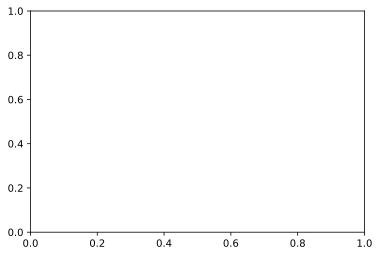

In [121]:
# 定义优化器
lr = 0.1
optimizer = torch.optim.SGD([W, b], lr=lr)

# 定义损失函数
loss = cross_entropy

# 训练模型
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

In [123]:
def predict_ch3(net, test_iter, n=6):
  """
  predict labels
  """

  for X, y in test_iter:
    break
  trues = get_fashion_mnist_labels(y)
  preds = get_fashion_mnist_labels(net(X).argmax(dim=1))
  titles = [true + "\n" + pred for true, pred in zip(trues, preds)]
  plt.show_images(X[0:6].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

AttributeError: module 'matplotlib.pyplot' has no attribute 'show_images'

# Softmax Regression with `pytorch`

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TypeError: 'int' object is not iterable

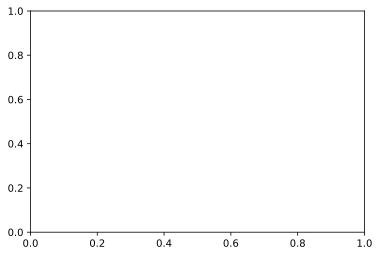

In [122]:
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)


net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)